# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## What it is about

Sparkify is an imaginary music streaming platform. The data provided is user activity data on the platform. Users can use the plattform in a free or in a paid version. Natuarally, the more paid accounts there are the better. Vice versa, users quitting the paid version or even the free version results in less direct and indirect revenue for Sparkify. This excercise project is done as the final project in the Udacity "Data Scientist" course and aims at trying to predict what users are likely to "churn" i.e. quit the paid version (or free version) alltogether. 
An understanding of who might be more likely to quit would then be the basis for the planning of countermeasures i.e. special offers or questionaires etc. . The countermeausres are not part of the excercise anymore.

This will be done by using Python and Spark to

    1) load, clean and analyze the data. Exploratory Data Analysis (EDA)
    2) build features to be used for the machine learning algoriths and modelling
    3) model the data
    4) analyze the modeling results
    
### Why using Spark
The data set here is 0,128 GB. Spark is the tool of choice to analyse much bigger datasets. It is used here as a training ground for handling bigger datasets in the future. Due to several issues on my local machine and in tuser workspace (mostly to do with memory error messages) the focus here is on the small dataset due to time constraints.

### Resources
In order to overcome certain challenges on my local laptop and on the workspace provided by Udacity, several resources have been used. Besides the extracuricular course on Spark from Udacity the websites stockoverflow.com , pyspark documentation and github.com have been used as well as help section of Udacity.

In [1]:
# Import libraries
from pyspark.sql               import   SparkSession
from pyspark.sql.functions     import   avg,           \
                                        count,         \
                                        countDistinct, \
                                        col,           \
                                        desc,          \
                                        isnan,         \
                                        max,           \
                                        mean,          \
                                        min,           \
                                        round,         \
                                        udf,           \
                                        when        

from pyspark.sql.types         import   IntegerType
from pyspark.ml                import   Pipeline
from pyspark.ml.feature        import   OneHotEncoderEstimator, \
                                        StringIndexer,          \
                                        VectorAssembler

from pyspark.ml.classification import   RandomForestClassifier
from pyspark.ml.classification import   LogisticRegression,     \
                                        GBTClassifier,          \
                                        NaiveBayes

from pyspark.ml.evaluation     import   BinaryClassificationEvaluator,    \
                                        MulticlassClassificationEvaluator

from pyspark.mllib.evaluation  import   BinaryClassificationMetrics,       \
                                        MulticlassMetrics

from pyspark.ml.tuning         import   CrossValidator,                    \
                                        ParamGridBuilder

import numpy    as np
import pandas   as pd
import math
import datetime
import time
import re
import matplotlib.pyplot as plt
import seaborn           as sns

start_1=time.time()     # to see how long compilation of the whole notebook takes. Cf. time calculation at the end of the notebook

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName('Sparkify')     \
    .getOrCreate()

In [3]:
print('Duration so far: {0:.1f} minutes'.format((time.time() - start_1)/60))

Duration so far: 0.1 minutes


# Load Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or **missing data** - for example, records without userids or sessionids. 

In [4]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [5]:
df.count() 
# number of rows in dataset:

286500

In [6]:
df.distinct().count() 
# number of unique rows:

286500

In [7]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.select(countDistinct("userId")).show()
# Unique users:

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [10]:
df.select(countDistinct("location")).show()
#Unique locations:

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



In [11]:
df.select(countDistinct("artist")).show()
#Unique artists:

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+



#### There are about halfs as many unique locations as unique users in the small dataset.

In [12]:
df.select(countDistinct("gender")).show()     

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                     2|
+----------------------+



## Column names and first line as example

In [13]:
df.limit(1).toPandas()      # output better readable than df.take(1) and df.show(1): show structure 
                            # but also limit line numbers that are converted toPandas to save memory and speed up the output

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [14]:
df.show(n=1, truncate=False, vertical=True)     # vertical: to visually optimize output of datafram header 
                                                # no truncate: to show complete cell content of UserAgent

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

### Counting emty cells (NaN's & isNull's) to check amount and location of missing data

In [15]:
%%time
df.toPandas().isnull().sum()

CPU times: user 3.76 s, sys: 310 ms, total: 4.07 s
Wall time: 14.2 s


artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

-->  8 346 missing: 
+ names
+ location
+ registration

        --> Possible visits without being logged in.

--> 58 392 missing 
* artist
* length
* song

        --> Possible user activity without playing a song. Could be due to technical issues or just other activities.

#### To give a visual showing the amount of NaNs in the dataframe, the package "MissingNo" ist used. If you do not have this package or it is not supported, just outcomment the next command box or set as "raw".

# Clean Dataset

#### Lines in the df with emtpy `userId` are useless when it comes predicting which user is more likely to quit the service. 
#### --> therefore deleting lines with empty userId.

In [16]:
df_clean = df.filter(df['userID']!='')
empties_per_col = df_clean.toPandas().isnull().sum()
empties_per_col

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

In [17]:
empties_per_col[0]
# Number of activities where no song was played:

50046

In [18]:
empties_per_col[0] / df_clean.count() *100
# percentage of activities where no song was played [%]:

17.992191376000342

#### The above 18 % of all entries is a high proportion. Also it might be very interesting to analyse those activities where no song was played. For example could a user be more likely to quit if he/she had lots of activities without playing a song. E.g. due to technical issues or the like. 
#### --> Keep those rows of data.

In [19]:
df_clean.count()

278154

In [20]:
df.count()-df_clean.count()

8346

#### --> Same number as number of empty userId's, Therefore: In the original df, if the userId is empty, then the song-related cells are also empty. -->  Hypothesis: Makes sense: playing of songs not possible if not logged in (userId visible).


### Checking the effect of cleaning by comparing distinct values of old and new dataframes

In [21]:
df      .select('page'). distinct().show(22)
df_clean.select('page'). distinct().show(19)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|         

In [22]:
print(df      .select('page'). distinct().count())
print(df_clean.select('page'). distinct().count())

22
19


#### In df_clean, the activities with the following pages have been cleaned out:
+ login
+ submit registration
+ register

#### --> We still have that data in the original dataframe but we can not use it to predict churn as we do not know the userId for those activities.

In [23]:
df       .select('method'). distinct().show()
df_clean .select('method'). distinct().show() 

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [24]:
df      .select('auth'). distinct().show()
df_clean.select('auth'). distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



#### Rows with "Logged Out" and "Guest" were cleaned out. That is ok for our purpose to predict userIds that are likely to quit.

In [25]:
df       .select('level'). distinct().show()
df_clean .select('level'). distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [26]:
df      .select('status'). distinct().show()
df_clean.select('status'). distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [27]:
df_clean.count()
# number of rows:

278154

### Closer Look on the data

In [28]:
print(df      .select('userID').dropDuplicates().count())
print(df_clean.select('userID').dropDuplicates().count())
count_users = df_clean.select('userID').dropDuplicates().count()

# Apparantly there was one duplicate row with a duplicate userId.

226
225


In [29]:
# compare to extracurriclar lesson, ipynb number 6
count_women = df_clean.filter(df_clean.gender == 'F') \
    .select('userId', 'gender')  \
    .dropDuplicates()            \
    .count()

count_women

104

In [30]:
count_women / count_users * 100
# ratio of women in [%]

46.22222222222222

### Visualising most played artist

In [31]:
# For diagram showing Most played artists
most_played_artists = df_clean.filter(df_clean.page == 'NextSong') \
    .select('Artist')            .groupBy('Artist') \
    .agg({'Artist':'count'})     .withColumnRenamed('count(Artist)', 'Artist_played') \
    .sort(desc('Artist_played'))

In [32]:
most_played_artists = most_played_artists.withColumn("Artist_played", most_played_artists["Artist_played"].cast(IntegerType()))

In [33]:
n=3       # n needs to be 3 or higher for code below to work
most_played_artists.show(n)

+--------------------+-------------+
|              Artist|Artist_played|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
+--------------------+-------------+
only showing top 3 rows



In [34]:
second_column = most_played_artists.select(most_played_artists.columns[1])

In [35]:
# testing code for the for-loop below
second_column.take(n)[2][0]

1236

In [36]:
first_column = most_played_artists.select(col("Artist")).take(n)
first_column

[Row(Artist='Kings Of Leon'),
 Row(Artist='Coldplay'),
 Row(Artist='Florence + The Machine')]

In [37]:
list_artist_played = []
for i in range(n):
    list_artist_played.append(second_column.take(n)[i][0])
print(list_artist_played)

[1841, 1813, 1236]


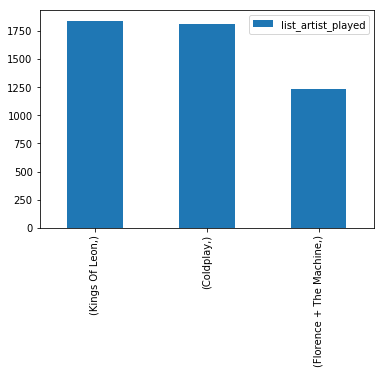

In [38]:
index = first_column
dft = pd.DataFrame({'list_artist_played': list_artist_played}, index=index)
dft.plot.bar();

#### Analyzing time stamps

In [39]:
df_clean.select('ts', 'registration').describe().show(truncate=False)

+-------+---------------------+---------------------+
|summary|ts                   |registration         |
+-------+---------------------+---------------------+
|count  |278154               |278154               |
|mean   |1.5409589154318713E12|1.5353588340844272E12|
|stddev |1.5068287123306298E9 |3.291321616327586E9  |
|min    |1538352117000        |1521380675000        |
|max    |1543799476000        |1543247354000        |
+-------+---------------------+---------------------+



#### Converting the time stamps to readable dates and times

In [40]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_clean = df_clean.withColumn('time',             get_time(df['ts']))
df_clean = df_clean.withColumn('registrationTime', get_time(df['registration']))

In [41]:
df_clean.show(1, vertical = True)

-RECORD 0--------------------------------
 artist           | Martha Tilston       
 auth             | Logged In            
 firstName        | Colin                
 gender           | M                    
 itemInSession    | 50                   
 lastName         | Freeman              
 length           | 277.89016            
 level            | paid                 
 location         | Bakersfield, CA      
 method           | PUT                  
 page             | NextSong             
 registration     | 1538173362000        
 sessionId        | 29                   
 song             | Rockpools            
 status           | 200                  
 ts               | 1538352117000        
 userAgent        | Mozilla/5.0 (Wind... 
 userId           | 30                   
 time             | 2018-10-01 00:01:57  
 registrationTime | 2018-09-28 22:22:42  
only showing top 1 row



In [42]:
df_clean.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [43]:
length_max = df.agg({"length": "max"}).collect()[0][0]
length_max / 60

50.4110945

### Histograms of categorical columns

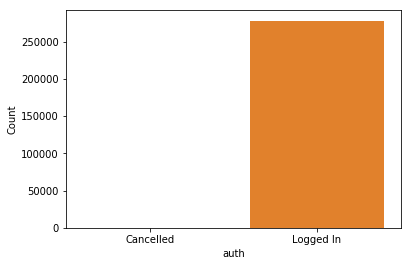

In [44]:
temp_df = df_clean.groupBy('auth').count().toPandas()
sns.barplot(temp_df['auth'], temp_df['count'])
plt.xlabel('auth')
plt.ylabel('Count')
plt.legend(loc=0)
plt.show()

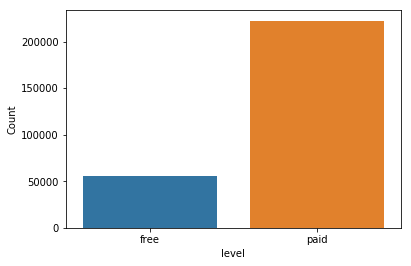

In [45]:
temp_df = df_clean.groupBy('level').count().toPandas()
sns.barplot(temp_df['level'], temp_df['count'])
plt.xlabel('level')
plt.ylabel('Count')
plt.legend(loc=0)
plt.show()

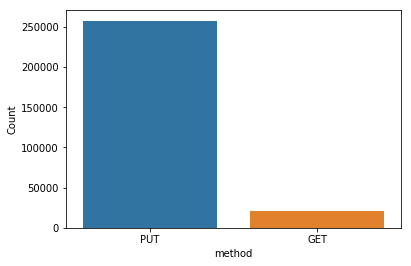

In [46]:
temp_df = df_clean.groupBy('method').count().toPandas()
sns.barplot(temp_df['method'], temp_df['count'])
plt.xlabel('method')
plt.ylabel('Count')
plt.legend(loc=0)
plt.show()

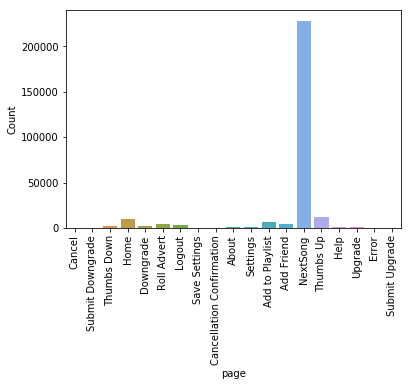

In [47]:
temp_df = df_clean.groupBy('page').count().toPandas()
sns.barplot(temp_df['page'], temp_df['count'])
plt.xlabel('page')
plt.ylabel('Count')
plt.legend(loc=0)
plt.xticks(rotation=90)
plt.show()

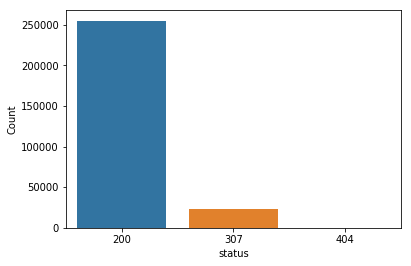

In [48]:
temp_df = df_clean.groupBy('status').count().toPandas()
sns.barplot(temp_df['status'], temp_df['count'])
plt.xlabel('status')
plt.ylabel('Count')
plt.legend(loc=0)
plt.show()

#### Most diagrams lean on either one side or the other (skew). This means that they either need to be normalized for modelling or we apply different key performance parameters to evaluate the models to be employed.

# How to define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [49]:
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [50]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates().count()

52

In [51]:
df_clean.filter(df['page']=='Cancellation Confirmation').count()

52

In [52]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
+---------+



####  Churn: a new column churn_user will be defined and value set as 1 if the page "Cancellation Confirmation" was visited.

### Defining Churn

In [53]:
# get a list of all users who churned
user_churned = df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates()
user_churned_list = [row['userID'] for row in user_churned.collect()]

# flag the users as churn who had an activity of Cancellation Confirmation (list above) 
is_churn_udf = udf(lambda x: 1 if x in user_churned_list else 0, IntegerType())
df_clean = df_clean.withColumn('churn', is_churn_udf('userID'))

In [54]:
df_clean.filter(df_clean['churn']==0).count()

233290

In [55]:
df_clean.filter(df_clean['churn']==1).count()

44864

In [56]:
df_clean.count()

278154

In [57]:
non_churners = df_clean.filter(df_clean['churn']==0).dropDuplicates(['userId']).count()
non_churners

173

In [58]:
churners = df_clean.filter(df_clean['churn']==1).dropDuplicates(['userId']).count()
churners

52

In [59]:
ratio_of_churn_users = churners / (churners + non_churners)
print('{0:.1f} % ... percentage of churners'.format(ratio_of_churn_users * 100))

23.1 % ... percentage of churners


In addition, downgrading may be another interesting target variable to study, which is reflected by the `Submit Downgrade` event in the `page` column. We'll also include it here using the similar method above.

### Defining Downgrade

In [60]:
user_downgrade = df_clean.filter(df['page']=='Submit Downgrade').select('userID').dropDuplicates()
user_downgrade_list = [r['userID'] for r in user_downgrade.collect()]

is_downgrade_udf = udf(lambda x: 1 if x in user_downgrade_list else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade', is_downgrade_udf('page'))

In [61]:
df_clean.dropDuplicates(['userID']).select('auth', 'level', 'page', 'userId', 'churn', 'downgrade').show(6)

+---------+-----+--------+------+-----+---------+
|     auth|level|    page|userId|churn|downgrade|
+---------+-----+--------+------+-----+---------+
|Logged In| free|NextSong|100010|    0|        0|
|Logged In| free|NextSong|200002|    0|        0|
|Logged In| free|NextSong|   125|    1|        0|
|Logged In| paid|    Home|   124|    0|        0|
|Logged In| paid|    Home|    51|    1|        0|
|Logged In| free|NextSong|     7|    0|        0|
+---------+-----+--------+------+-----+---------+
only showing top 6 rows



In [62]:
df_clean.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'time',
 'registrationTime',
 'churn',
 'downgrade']

#### --> the four new columns have been added at the end: `time`, `registrationTime`, `churn` and `downgrade`

### Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [63]:
def plot_churn_influence(df, drop_label, x_label):
    '''
    Plotting histograms fo the columns of the dataframe with the hue of churn/no-churn 
    Input:  df:          the df from above
            drop_label:  list of string(s), the name(s) of the column(s) to drop the duplicates
            x_label:     string, name of column for the histgram and name of x-axis
    Output: None
    ''' 
    fig, ax = plt.subplots(figsize=(8, 6))

    df_temp = df.dropDuplicates(drop_label).groupBy([x_label, 'churn']).count().toPandas()
    sns.barplot(x=x_label, y='count', hue='churn', data=df_temp)
    plt.tight_layout()
    sns.set(font_scale=2)
    plt.show()

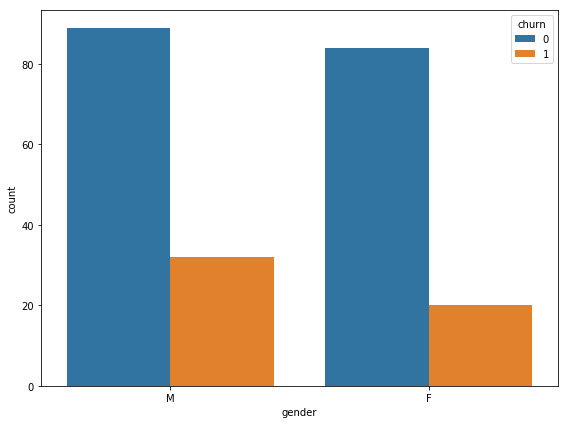

In [64]:
plot_churn_influence(df_clean, ['userID'], 'gender')

#### --> Women are less likely to churn.

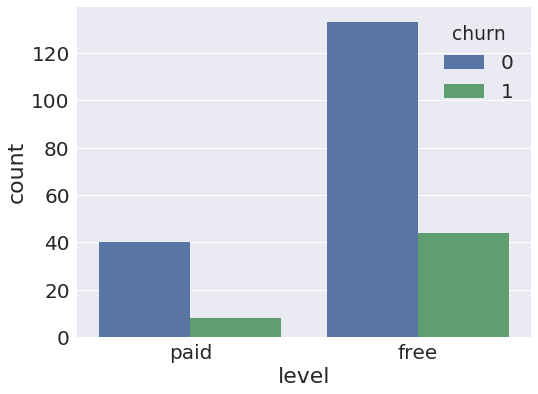

In [65]:
plot_churn_influence(df_clean, ['userID'], 'level')

#### ---> it is hard to make a conclusion here as we would have to normalize those numbers (i.e. account for the different numbers of non-churners and churners. A lot fewer users are churners. 

In [66]:
df_clean.select('status').dropDuplicates().sort('status').show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



#### Explanantion of code: "200": OK  ||  "307":  Temporary Redirect  || "404":  Not Found

In [67]:
df_status = df_clean.groupBy(['churn','status']).count().toPandas()
tot_churn_status = df_status[df_status['churn'] == 1]['count'].sum()
tot_nonchurn_status = df_status[df_status['churn'] == 0]['count'].sum()
df_status['dist_by_churn'] = df_status.apply(lambda x: x['count'] / tot_churn_status * 100 
                                             if x['churn'] == 1 else x['count'] / tot_nonchurn_status * 100, axis=1)

df_status.sort_values(['churn', 'status'], axis=0)

,churn,status,count,dist_by_churn
4,0,200,213581,91.551717
5,0,307,19489,8.353980
2,0,404,220,0.094303
0,1,200,41137,91.692671
3,1,307,3695,8.236002
1,1,404,32,0.071327


#### Very interesting: I would have assumed that the error 404 comes up a lot more for the users who churned, because they might be not happy with the technical performance of the service. But that seems to be not true in this small dataset. Therefore and because there also seems to be not much difference regarding 307 and 200 the "status" might not be the best feature for machine learning.

### What users mostly do on Sparkify (what pages are visited)

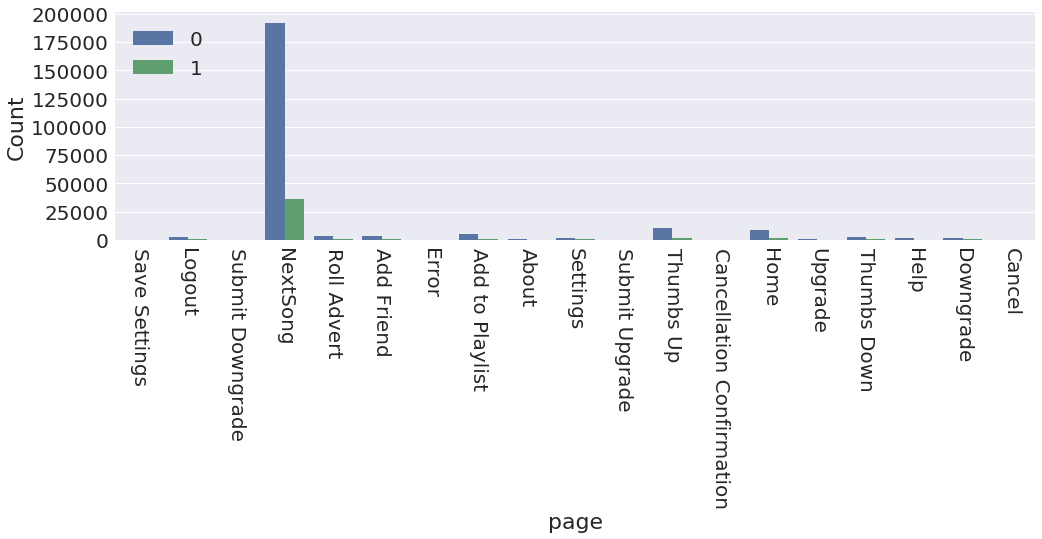

In [68]:
fig, ax = plt.subplots(figsize = (15, 8))
df_temp = df_clean.groupBy(['churn','page']).count().toPandas()
sns.barplot(x='page', y='count', hue='churn', data=df_temp, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('page')
ax.tick_params(axis='x', rotation = -90)
ax.legend(loc = 0)
plt.tight_layout()
sns.set(font_scale=1)
plt.show()

#### The graph above shows that NextSong is the main activity on Sparkify, as expected. But as there are a lot more non-churners than churners, it does not tell us much about who is more likely to churn. For that we would have to normalize the data.

### Exploring location

In [69]:
df_clean.select('location').distinct().count()

114

#### --> With 114 locations but only 52 churn-users, the location is not the best feature. But, once the dataset is huge, there will be a lot more users and this data will possibly become more usefull.

In [70]:
df_clean.select('location').distinct().sort('location').show(3, truncate=False)

+---------------------------+
|location                   |
+---------------------------+
|Albany, OR                 |
|Albany-Schenectady-Troy, NY|
|Alexandria, LA             |
+---------------------------+
only showing top 3 rows



### Exploring "US states"

In [71]:
# Splitting the State information from the location
get_state_udf = udf(lambda x: x.split(',')[1].strip().split('-')[0])
df_clean = df_clean.withColumn('state', get_state_udf('location'))

In [72]:
df_clean.select('state').distinct().show(3)

+-----+
|state|
+-----+
|   AZ|
|   SC|
|   LA|
+-----+
only showing top 3 rows



In [73]:
df_clean.select('state').distinct().count()

41

#### --> With 41 states but only 52 churn-users, the location is not the best feature either. But, once the dataset is huge, there will be a lot more users and this data will possibly become more usefull.

### Exploring "userAgent" by extracting the platform to analyse which device is used

In [74]:
df_clean.select('userAgent').distinct().count()

56

In [75]:
df_clean.select('userAgent').distinct().show(4, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
+--------------------------------------------------------------------------------------------------------------------------+


In [76]:
trial_str = df_clean.select('userAgent').distinct().collect()[0][0]
trial_str

'"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'

In [77]:
pattern = r'\(([^\(\)]*)\)'
re.findall(pattern, trial_str)[0].split(';')[0]

'Macintosh'

In [78]:
# Extract the platform from the userAgent
get_os_udf = udf(lambda x: re.findall(pattern, x)[0].split(';')[0])
df_clean = df_clean.withColumn('platform', get_os_udf('userAgent'))

In [79]:
df_clean.select('platform').distinct().count()

10

In [80]:
df_clean.select('platform').distinct().show()

+--------------+
|      platform|
+--------------+
|          iPad|
|           X11|
|Windows NT 6.3|
|        iPhone|
|Windows NT 6.2|
|     Macintosh|
|Windows NT 5.1|
|    compatible|
|Windows NT 6.0|
|Windows NT 6.1|
+--------------+



In [81]:
def vis_dist_percentage(df, col):
    '''
    Function to visualize the distribution patterns in percentage based on two user groups in the dataset
     
    Args:
        df: a spark Dataframe
        col: a string, the name of the column to visualize
        
    Returns:
        None
    '''
    
    df_temp = df.groupBy(['churn',col]).count().toPandas()
    tot_churn_events = df_temp[df_temp['churn'] == 1]['count'].sum()
    tot_nonchurn_events = df_temp[df_temp['churn'] == 0]['count'].sum()
    df_temp['percentage_by_churn'] = df_temp.apply(lambda x: x['count'] / tot_churn_events * 100 
                                                   if x['churn'] == 1 else x['count'] / tot_nonchurn_events * 100, axis=1)
    df_temp.sort_values(['churn', col], axis=0, inplace=True)
    fig, ax = plt.subplots(figsize = (15, 8))
    
    sns.barplot(x=col, y='percentage_by_churn', hue='churn', data=df_temp, ax=ax)
    ax.set_ylabel('Percentage', fontsize = 16)
    ax.set_xlabel(col, fontsize = 16)
    ax.tick_params(axis='y', labelsize = 15)
    ax.tick_params(axis='x', labelsize = 15, rotation = -90)
    ax.legend(loc = 0, fontsize = 16)
    plt.tight_layout()
    plt.show()

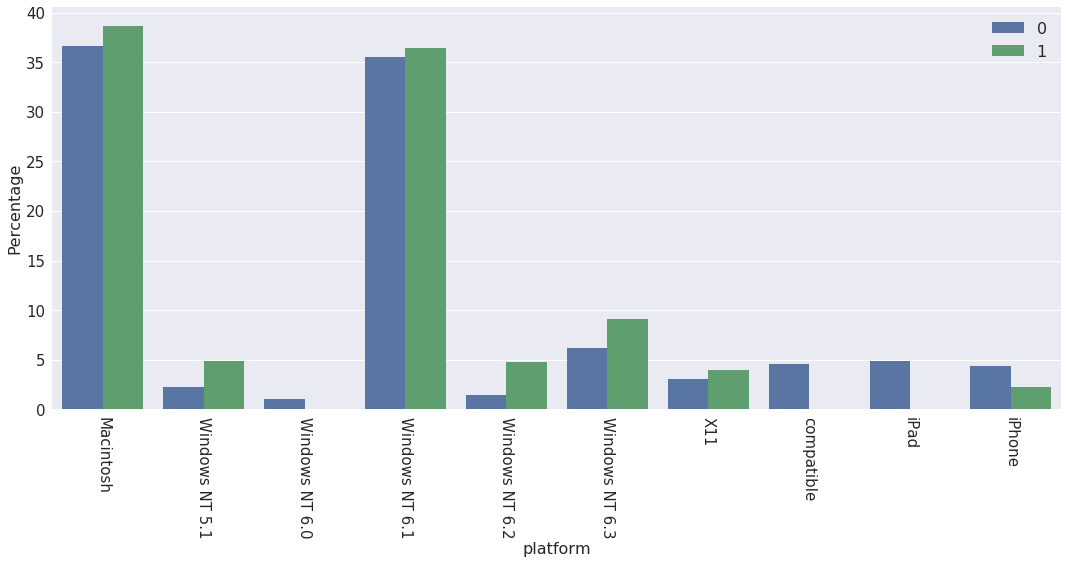

In [82]:
vis_dist_percentage(df_clean, 'platform')

#### This is interesting: the likelihood to churn is higher if a user is using a stationary device. If the users has a more expensive handheld device, like an iPad or an iPhone, there are less churns. 

--> Hypothesis: maybe iPhone and iPad users are less price sensitive and they use the service more flexibly which can help staying a customer.

## Exploring the timing of activity
For churners and non-churners

In [83]:
# Check the range of the time of the events
max_time = df_clean.groupBy().max('ts').collect()[0][0]
min_time = df_clean.groupBy().min('ts').collect()[0][0]
print('min_time: {}, max_time: {}.'
      .format(datetime.datetime.fromtimestamp(min_time / 1000).strftime('%Y-%m-%d %H:%M:%S'),
              datetime.datetime.fromtimestamp(max_time / 1000).strftime('%Y-%m-%d %H:%M:%S')))

min_time: 2018-10-01 00:01:57, max_time: 2018-12-03 01:11:16.


#### As there are only about two full months (about 8 weeks) of only one year (2018) and only 52 churn users in this small dataset, we will not analyse the effect of years, months and also weeks on churning in the EDA section. It seems just not enough data. We will however look at the time of the day and prepare the remaining time columns so that they can be used in the modelling. Especially with bigger datasets this could be beneficial.

In [84]:
get_year    = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).year,          IntegerType())
get_month   = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).month,        IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).isoweekday(), IntegerType())
get_hour    = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour,         IntegerType())

df_clean = df_clean.withColumn('year',    get_year('ts'))
df_clean = df_clean.withColumn('month',   get_month('ts'))
df_clean = df_clean.withColumn('weekday', get_weekday('ts'))
df_clean = df_clean.withColumn('hour',    get_hour('ts'))

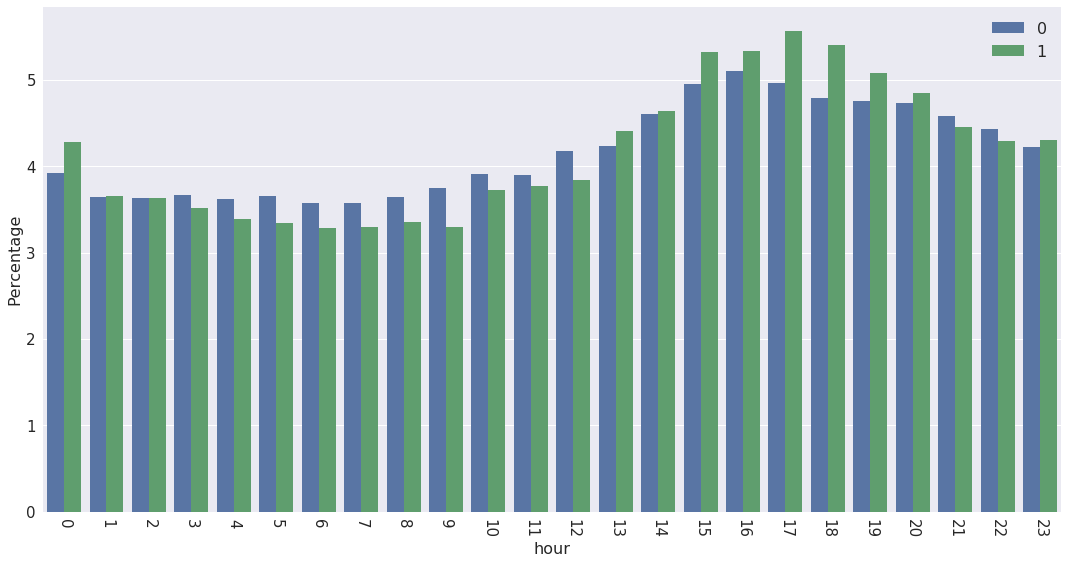

In [85]:
vis_dist_percentage(df_clean, 'hour')

#### --> Churners are more active in the afternoon.
#### --> Non-churners are more active in the morning.

#   


## As for exploring quantity of activities, this is difficult. E.g. if we look at the "average total time of listening" to music then we would have to take into account that users who quit can not spend more time on listening. So the total times of churners will likely be smaller than the total time of non-churners. For the further reasons below we will nevertheless have those properties as features later.
Also, in the recorded time period, there will be churners who joined before the start date of the data set. And we do not have the activity data from before that time period before the data set starts. That makes any comparison difficult, especially because it is only two months.
However, with a bigger dataset that covers a longer time period, this effect will get less important and the feature more interessting to analyze. I would then analyse the following: "average playtime of songs per day" for churners and non-churners: also with a focus on the periods right after registration and for the periods shortly before the churners cancel.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

--> If you are **working in the classroom workspace, you can just extract features based on the small subset** of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## + Categorical

1) userID

2) gender

3) churn

4) level

5) platform

6) state


## + Numerical

1) numEvents

2) regDays

3) ratioAddFriend

4) ratioAddtoPlaylist

5) ratioNextSong

6) ratioRollAdvert

7) ratioThumbsDown

8) ratioThumbsUp

9) ratioFirstHalf

10) ratioArtists

11) numPerSession

12) timePerEvent


### Categorical Feature 1 - 3: userId, Gender & Churn

In [86]:
# Create dataframe with userID, gender and churn columns
data = df_clean.dropDuplicates(['userID']).select('userID', 'gender', 'churn')

In [87]:
data.count()

225

In [88]:
data.filter(data['churn']==0).dropDuplicates(['userId']).count()

173

In [89]:
data.filter(data['churn']==1).dropDuplicates(['userId']).count()

52

### Categorical Features 4 - 6: Level, Plattform and State
As mentioned earlier, `plattform` and `state` are used as a preparation for bigger datasets because 52 churners is not many if there are 41 states and only about a dozen platforms. Meaning the number of churners seems small in order to get strong statistics. For illustration: if the users would be evenly distributed among the states, then there are not even 2 churners per state. Just one more or less churner in a state would yield a ver big relative change of churners per state but would only be a small change nevertheless.

In [90]:
# Adding level, platform, and location (state) of the last activity of the user
df_clean = df_clean.orderBy('userID', 'ts', ascending = False)
df_cat = df_clean.dropDuplicates(['userID']).select('userID', 'level', 'platform', 'state')
data = data.join(df_cat, 'userID')

## + Numerical

1) numEvents

2) regDays

3) ratioAddFriend

4) ratioAddtoPlaylist

5) ratioNextSong

6) ratioRollAdvert

7) ratioThumbsDown

8) ratioThumbsUp

9) ratioFirstHalf

10) ratioArtists

11) numPerSession

12) timePerEvent

#### Numerical feature 1: `numEvents`number of events per user 

In [91]:
df_events = df_clean.groupBy('userID').count().withColumnRenamed('count', 'numEvents')
df_events.show(5)

+------+---------+
|userID|numEvents|
+------+---------+
|200002|      474|
|100010|      381|
|   125|       11|
|     7|      201|
|    51|     2464|
+------+---------+
only showing top 5 rows



#### Numerical feature 2: `regDays` "number of days between registration and last activity of each user"
As mentioned above though, this features heavily depends on the fact if the two months time period covered by the small dataset is long or short in comparision to the time of membership of churners. 

In [92]:
df_reg = df_clean.select('userID', 'registration').dropDuplicates()
last_ts = df_clean.select('userID', 'ts').groupBy('userID').max()

df_reg = df_reg.join(last_ts, 'userID')
df_reg = df_reg.withColumn('regDays', (df_reg['max(ts)'] - df_reg['registration']) / (1000 * 60 * 60 * 24))
df_reg = df_reg.drop('registration', 'max(ts)')

df_reg.select("*",round("regDays", 1)).show(5)

+------+------------------+-----------------+
|userID|           regDays|round(regDays, 1)|
+------+------------------+-----------------+
|100010| 55.64365740740741|             55.6|
|200002| 70.07462962962963|             70.1|
|   125| 71.31688657407408|             71.3|
|   124|131.55591435185184|            131.6|
|    51|19.455844907407407|             19.5|
+------+------------------+-----------------+
only showing top 5 rows



#### Calculating total time per user

In [93]:
df_time = df_clean.groupBy(['userID']).sum('length').withColumnRenamed('sum(length)', 'totalTime')
df_time.select("*",round("totalTime")).show(5)

+------+-----------------+-------------------+
|userID|        totalTime|round(totalTime, 0)|
+------+-----------------+-------------------+
|200002|94008.87593999998|            94009.0|
|100010|66940.89735000003|            66941.0|
|   125|        2089.1131|             2089.0|
|     7|       38034.0871|            38034.0|
|    51|523275.8428000004|           523276.0|
+------+-----------------+-------------------+
only showing top 5 rows



#### Calculating: number of page visits per user for numerical features 3 - 8

In [94]:
def extract_events(df, col, event_name):
    '''
    extracting the event "event_name" of the column "col" of the dataframe "df" in question 
    ''' 
    df_event = df.filter(df[col] == event_name).groupBy('userID').count().\
    withColumnRenamed('count', 'num'+event_name.replace(' ', ''))
    
    return df_event

In [95]:
events = ['Add Friend', 'Add to Playlist', 'NextSong', 'Roll Advert', 'Thumbs Down', 'Thumbs Up']
for event in events:
    df_temp = extract_events(df_clean, 'page', event)
    data = data.join(extract_events(df_clean, 'page', event), 'userID')

#### Calculation for numerical feature: number of artists listened to

As mentioned above though, this features heavily depends on the fact if the two months time period covered by the small dataset is long or short in comparision to the time of membership of churners. 

In [96]:
df_artist = df_clean.dropDuplicates(['userID', 'artist']).groupBy('userID').count().withColumnRenamed('count', 'numArtists')
df_artist.show(5)

+------+----------+
|userID|numArtists|
+------+----------+
|200002|       340|
|100010|       253|
|   125|         9|
|    51|      1386|
|   124|      2233|
+------+----------+
only showing top 5 rows



#### Calculating: number of sessions per user for feature 11

In [97]:
df_session = df_clean.dropDuplicates(['userID', 'sessionID']).groupBy('userID').count().withColumnRenamed('count', 'numSessions')
df_session.show(5)

+------+-----------+
|userID|numSessions|
+------+-----------+
|100010|          7|
|200002|          6|
|   125|          1|
|    51|         10|
|   124|         29|
+------+-----------+
only showing top 5 rows



#### Calculation for numerical feature 11: number of activites (page visits) per user before noon
This is chosen, as churners had more activity in the afternoon, as shown further above.

In [98]:
df_hour = df_clean.filter((df_clean['hour'] >= 1) & (df_clean['hour'] <= 12)).groupBy('userID').count()\
.withColumnRenamed('count', 'numFirstHalf')
df_hour.show(5)

+------+------------+
|userID|numFirstHalf|
+------+------------+
|200002|         113|
|100010|         186|
|   125|          11|
|     7|         130|
|    51|        1128|
+------+------------+
only showing top 5 rows



#### Joining numerical data to `data` of categorical features 1-4

In [99]:
for df_temp in [df_time, df_session, df_events, df_hour, df_artist, df_reg]:
    data = data.join(df_temp, 'userID')

### Numerical Features 3 -10: ratios of page visits and artists over total number of events, per user
3) ratioAddFriend

4) ratioAddtoPlaylist

5) ratioNextSong

6) ratioRollAdvert

7) ratioThumbsDown

8) ratioThumbsUp

9) ratioFirstHalf

10) ratioArtists

In [100]:
# get relative size of numbers (normalized to number of events)
numCols = ['numAddFriend', 'numAddtoPlaylist', 'numNextSong', 'numRollAdvert', 
           'numThumbsDown', 'numThumbsUp', 'numFirstHalf', 'numArtists']

for numCol in numCols:
    data = data.withColumn('ratio' + numCol[3:], (data[numCol] / data['numEvents']))
    data = data.drop(numCol)

### Numerical Features 11 & 12:  Number of Events per Session, Time per Session

In [101]:
# events per Session
data = data.withColumn('numPerSession', (data['numEvents'] / data['numSessions']))
# time per session
data = data.withColumn('timePerEvent', (data['totalTime'] / data['numEvents']))
data = data.drop('numSessions')
data = data.drop('totalTime')

## Final features columns and check of correlation

In [102]:
data.columns

['userID',
 'gender',
 'churn',
 'level',
 'platform',
 'state',
 'numEvents',
 'regDays',
 'ratioAddFriend',
 'ratioAddtoPlaylist',
 'ratioNextSong',
 'ratioRollAdvert',
 'ratioThumbsDown',
 'ratioThumbsUp',
 'ratioFirstHalf',
 'ratioArtists',
 'numPerSession',
 'timePerEvent']

In [103]:
data.show(1, vertical = True)

-RECORD 0----------------------------------
 userID             | 100010               
 gender             | F                    
 churn              | 0                    
 level              | free                 
 platform           | iPhone               
 state              | CT                   
 numEvents          | 381                  
 regDays            | 55.64365740740741    
 ratioAddFriend     | 0.010498687664041995 
 ratioAddtoPlaylist | 0.01837270341207349  
 ratioNextSong      | 0.7217847769028871   
 ratioRollAdvert    | 0.13648293963254593  
 ratioThumbsDown    | 0.013123359580052493 
 ratioThumbsUp      | 0.04461942257217848  
 ratioFirstHalf     | 0.4881889763779528   
 ratioArtists       | 0.6640419947506562   
 numPerSession      | 54.42857142857143    
 timePerEvent       | 175.6978933070867    
only showing top 1 row



In [104]:
%%time
data_tPand_corr = data.toPandas().corr()

CPU times: user 109 ms, sys: 25.6 ms, total: 134 ms
Wall time: 2min 1s


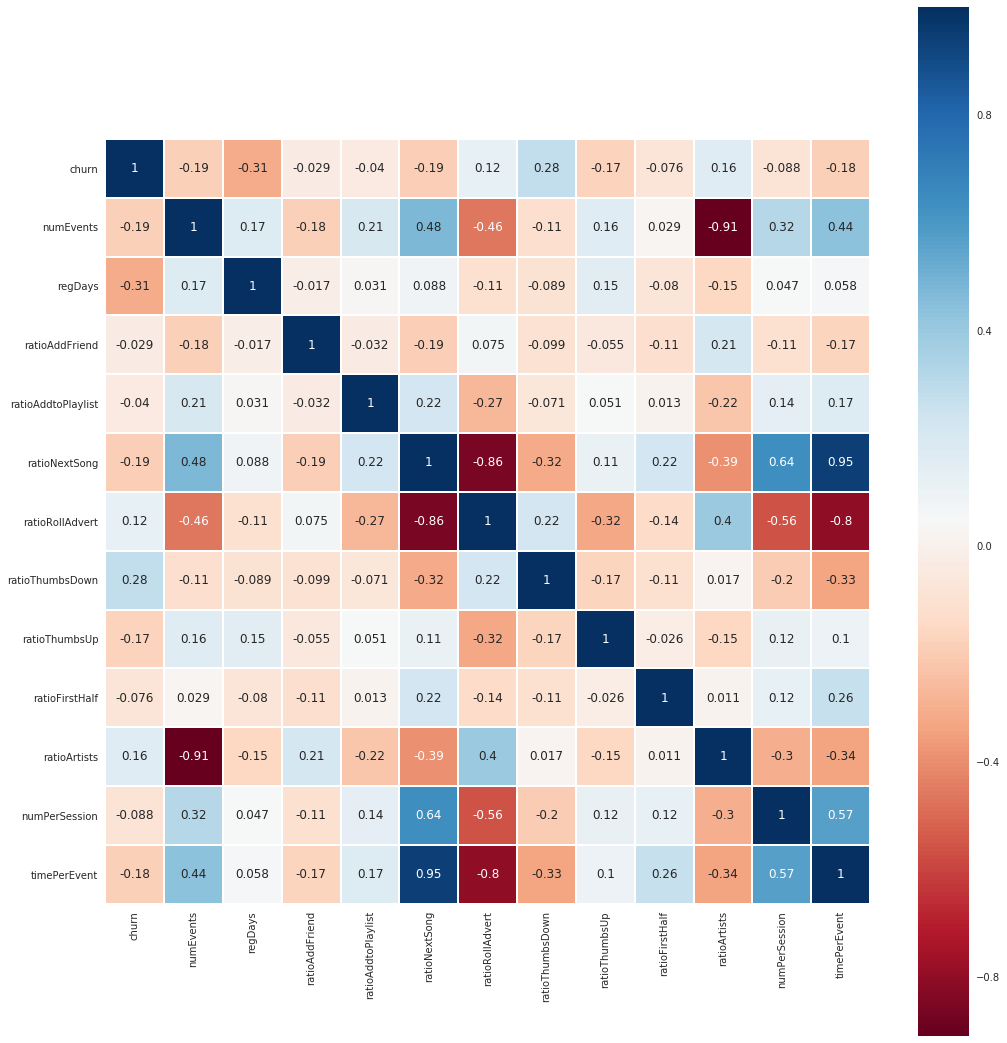

CPU times: user 1.38 s, sys: 59.4 ms, total: 1.44 s
Wall time: 1.8 s


In [105]:
%%time
#checking that there is low correlation of columns
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(data_tPand_corr, cmap='RdBu', linewidths = 1, square = True, annot = True)
plt.tight_layout()
plt.show()

Checking the degree of correlation between the columns of features: only slight correlation --> should work for modelling.

In [137]:
t_till_saving = (time.time() - start_1)/60
print('Duration till saving csv-file: {0:.1f} minutes'.format(t_till_saving))

Duration till saving csv-file: 27.1 minutes


In [139]:
startcsv=time.time()

In [140]:
# Dataframe is saved as comma separated file
data.write.csv('features_data.csv', mode = 'overwrite', header = True)

In [141]:
t_csv = (time.time() - startcsv)/60
print('Duration: {0:.1f} minutes'.format(t_csv))

Duration: 2.3 minutes


# Modeling

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set.**Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.**

As shown in the extracurricular lesson a pipeline is employed to prepare the modelling data, followed by the split into train- and test-data. The parameters are tuned the F1 score will be evaluated.
Since the compilation of the whole notebook took about half an hour in the workspace, several time durations are checked just for information purposes.

## Data Preparation

#### Extract, transform and load pipeline

In [179]:
# Creating the dummy variables for the categorical data with one-hot encodinger

data_cleaned = spark.read.csv('features_data.csv', inferSchema = True, header=True)
etl_stages = []

categorical_cols = ['gender', 'level', 'platform', 'state']
numerical_cols = [col for col in data_cleaned.columns if col not in categorical_cols]
numerical_cols.remove('churn')
numerical_cols.remove('userID')

for categorical_col in categorical_cols:
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + 'Index', stringOrderType='alphabetDesc')
    etl_stages.append(stringIndexer)
    
oh_encoder = OneHotEncoderEstimator(inputCols=[col + 'Index' for col in categorical_cols], outputCols=[col + 'Vec' for col in categorical_cols])
etl_stages.append(oh_encoder)

assemble_Vectors = VectorAssembler(inputCols=[col + 'Vec' for col in categorical_cols] + numerical_cols, outputCol='features') # Combine features
etl_stages.append(assemble_Vectors)
etl_pipeline = Pipeline(stages=etl_stages)

## Split in Train- and Test-data

In [180]:
# 70% train, 30% test split
data_cleaned = etl_pipeline.fit(data_cleaned).transform(data_cleaned)
train, test = data_cleaned.randomSplit([0.7, 0.3])

### Function to apply on the classification algorithms below

#### Evaluation function 1: checking the classification algorithm (model) with different parameters

In [181]:
def sum_model_performance(model, labels):
    '''
    Summarizing the hyper-parameters with scores for the model into a Dataframe
    Input:  model:  a fitted CrossValidatorModel
            labels: a list of strings, the name of the metric and the hyper-parameters
    Output: df: a Dataframe containing the hyper-parameters with the scores for the models
    '''
    df_lists = []
    
    for i, grid in enumerate(model.getEstimatorParamMaps()):
        df_list = []
        df_list.append(model.avgMetrics[i])
        for param in grid.values():
            df_list.append(param)
        df_lists.append(df_list)
        
    df = pd.DataFrame.from_records(df_lists, columns=labels)
    F1_train_max = df['F1 score'].max()
    print('{0:.3f} ... max. F1 score, train dataset'.format(F1_train_max))
    return df

#### Evaluation function 2: checking classification algorithm with best parameters with the test data

In [182]:
def test_metrics(model):
    '''
    Performance check of the best model on the test data
    Input:   model: a fitted CrossValidatorModel
    Output:  None
    '''
    pred    = model.bestModel.transform(test)
    F1_test = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='churn').evaluate(pred) 
    print('{0:.3f} ...      F1 score, test  dataset'.format(F1_test))
    
    return F1_test

#### Plotting function 3: for result of Confusion matrix method
The confusion matrix method will give an array that depicts the True Positives, False Positives, False Negatives, and True negatives.

The plot will give back the numbers and percentages for each category.

In [183]:
def plot_confmatrix(model):
    '''
    Function to calulate and visualize the confusion matrix
    Input:  model: a fitted CrossValidatorModel
    Output: None, but printing the confusion matrix and diagram.
    
    Code from: https://stackoverflow.com/questions/59839782/confusion-matrix-font-size 
    '''
    predictions = model.bestModel.transform(test)
    predictionAndLabels = predictions.rdd.map(lambda lp: (float(lp.prediction), float(lp.churn)))
    confmatr = MulticlassMetrics(predictionAndLabels).confusionMatrix().toArray()
    #confmatr = confmatr.astype('float') / confmatr.sum(axis = 1)[:, np.newaxis]
    print(confmatr)
    plt.figure(figsize = (16,5))
    sns.set(font_scale=2)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confmatr.flatten()]

    group_percentages = ["{0:.1%}".format(value) for value in
                         confmatr.flatten()/np.sum(confmatr)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(confmatr, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Normalized Confusion matrix\n');
    ax.set_xlabel('\nPredicted Churn Values')
    ax.set_ylabel('Actual Churn Values');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.show()
    print("The plot shows the values and the normalized fractions for each category of: True negatives, False Positives, False Negatives and True Positives.")
    

## Using and evaluating different supervised-learning classification algorithms

1) Logistic Regression

2) Random Forest

3) Gradient-Boosted Trees

4) Naive Bayes

As mentioned mentioned in the project description F1-score evaluation will be used due to the skewed data.

### 1) Logistic Regression

In [184]:
startlr=time.time()

In [185]:
lr = LogisticRegression(labelCol='churn')

param_grid_lr = ParamGridBuilder().addGrid(lr.aggregationDepth, [2, 10])  .addGrid(lr.elasticNetParam, [0, 0.3]) \
                                  .addGrid(lr.regParam, [0.01, 0.1, 0.3]) .build()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'), numFolds=3, seed=35)
lr_model = cv_lr.fit(train)

In [186]:
#start=time.time()
t_lr = (time.time() - startlr)/60
print('Duration: {0:.1f} minutes'.format(t_lr))

Duration: 3.7 minutes


In [187]:
lr_F1_train_max = sum_model_performance(lr_model, ['F1 score', 'regParam', 'elasticNetParam', 'aggregationDepth'])['F1 score'].max()
lr_F1_test = test_metrics(lr_model)

0.694 ... max. F1 score, train dataset
0.791 ...      F1 score, test  dataset


In [188]:
t_lr = (time.time() - startlr)/60
print('Duration: {0:.1f} minutes'.format(t_lr))

Duration: 3.7 minutes


[[ 30.   7.]
 [  3.   4.]]


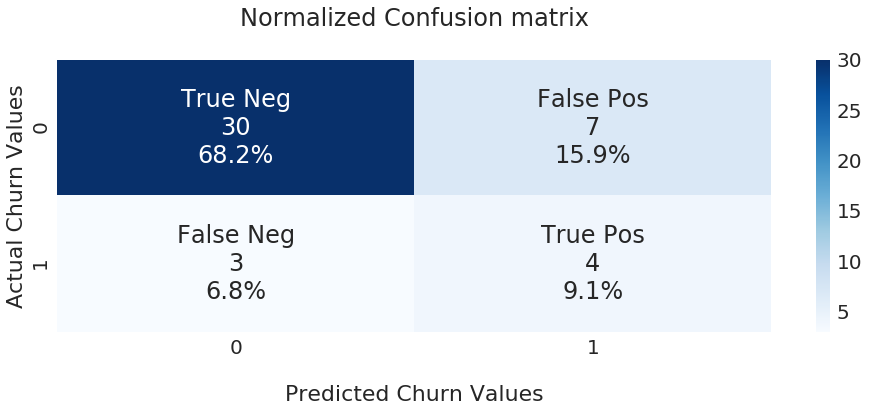

The plot shows the values and the normalized fractions for each category of: True negatives, False Positives, False Negatives and True Positives.


In [189]:
plot_confmatrix(lr_model)

### 2) Random Forest

In [190]:
startrf=time.time()

In [191]:
rf = RandomForestClassifier(labelCol='churn')

param_grid_rf = ParamGridBuilder()            .addGrid(rf.featureSubsetStrategy, ['sqrt', 'all']) \
    .addGrid(rf.impurity, ['entropy', 'gini']).addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [10, 20])           .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'),numFolds=3, seed=35)

rf_model = cv_rf.fit(train)

In [192]:
rf_F1_train_max = sum_model_performance(rf_model, ['F1 score', 'featureSubsetStrategy', 'impurity', 'maxDepth', 'numTrees'])['F1 score'].max()
rf_F1_test = test_metrics(rf_model)

0.834 ... max. F1 score, train dataset
0.845 ...      F1 score, test  dataset


In [193]:
t_rf = (time.time() - startrf)/60
print('Duration: {0:.1f} minutes'.format(t_rf))

Duration: 1.1 minutes


[[ 33.   4.]
 [  3.   4.]]


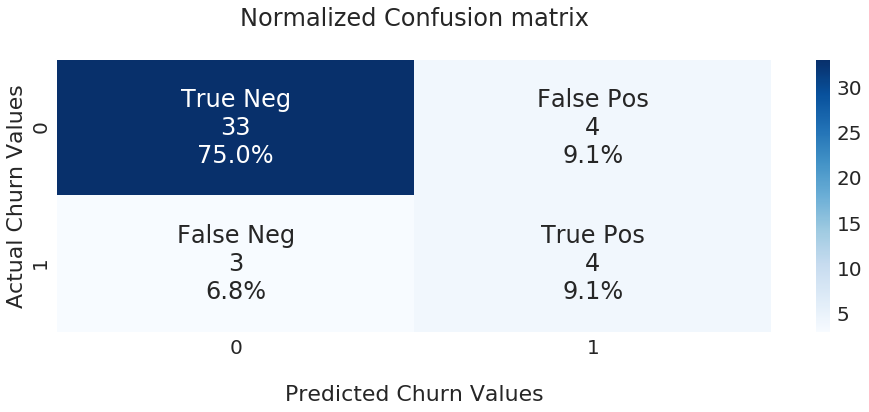

The plot shows the values and the normalized fractions for each category of: True negatives, False Positives, False Negatives and True Positives.


In [194]:
plot_confmatrix(rf_model)

### 3) Gradient-Boosted Trees

In [195]:
startgbt=time.time()

In [196]:
gbt = GBTClassifier(labelCol='churn')

param_grid_gbt = ParamGridBuilder()    .addGrid(gbt.featureSubsetStrategy, ['sqrt', 'all']) \
    .addGrid(gbt.maxIter, [10, 20])    .addGrid(gbt.maxDepth, [5, 10])   .addGrid(gbt.stepSize, [0.1, 0.3]) .build()

cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, 
                        evaluator=MulticlassClassificationEvaluator(labelCol='churn'), numFolds=3, seed=35)

gbt_model = cv_gbt.fit(train)

In [197]:
gbt_F1_train_max = sum_model_performance(gbt_model, ['F1 score', 'featureSubsetStrategy', 'maxIter', 'maxDepth', 'stepSize'])['F1 score'].max()
gbt_F1_test = test_metrics(gbt_model)

0.769 ... max. F1 score, train dataset
0.774 ...      F1 score, test  dataset


In [198]:
gbt_F1_test = test_metrics(gbt_model)

0.774 ...      F1 score, test  dataset


In [199]:
t_gbt = (time.time() - startgbt)/60
print('Duration: {0:.1f} minutes'.format(t_gbt))

Duration: 8.3 minutes


[[ 29.   8.]
 [  3.   4.]]


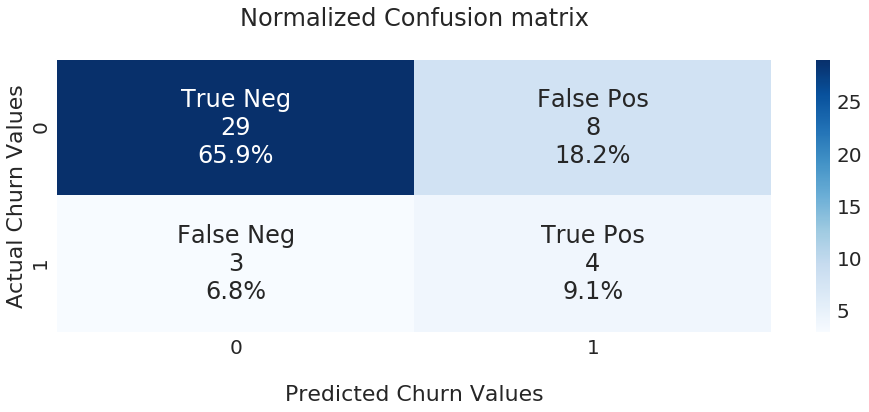

The plot shows the values and the normalized fractions for each category of: True negatives, False Positives, False Negatives and True Positives.


In [200]:
plot_confmatrix(gbt_model)

### 4) Naive Bayes

In [201]:
startnb=time.time()

In [202]:
nb = NaiveBayes(labelCol='churn')
param_grid_nb = ParamGridBuilder().addGrid(nb.smoothing, [0, 1, 5]).build()
cv_nb = CrossValidator(estimator=nb, estimatorParamMaps=param_grid_nb, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'),numFolds=3, seed=35)
nb_model = cv_nb.fit(train)

In [203]:
nb_F1_train_max = sum_model_performance(nb_model, ['F1 score', 'smoothing'])['F1 score'].max()
nb_F1_test = test_metrics(nb_model)

0.644 ... max. F1 score, train dataset
0.744 ...      F1 score, test  dataset


In [204]:
t_nb = (time.time() - startnb)/60
print('Duration: {0:.1f} minutes'.format(t_nb))

Duration: 0.1 minutes


[[ 25.  12.]
 [  1.   6.]]


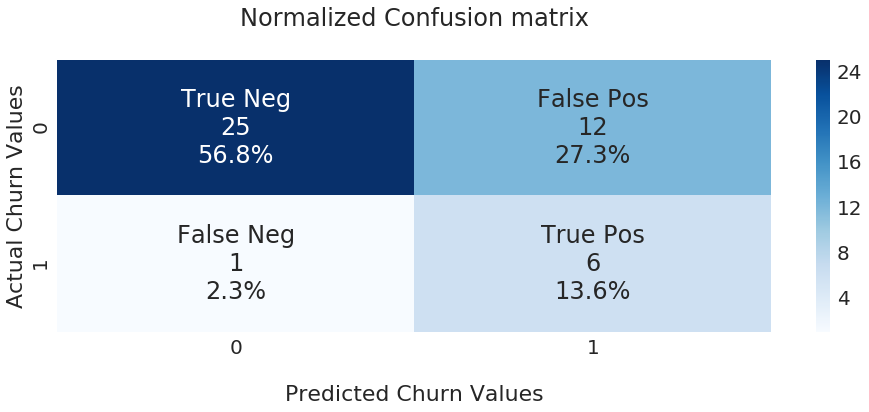

The plot shows the values and the normalized fractions for each category of: True negatives, False Positives, False Negatives and True Positives.


In [205]:
plot_confmatrix(nb_model)

## Results
### Overview of F1-scores, computing time and discussion

#### F1-score on test data

In [206]:
print("   F1 Scores  |")
print('train |  test | minutes  ')
print("-----------------------")
print('{0:.3f} | {1:.3f} | {2:.1f} min .... 1) Logistic Regression'   .format(lr_F1_train_max, lr_F1_test, t_lr))
print('{0:.3f} | {1:.3f} | {2:.1f} min .... 2) Random Forest'         .format(rf_F1_train_max, rf_F1_test, t_rf))
print('{0:.3f} | {1:.3f} | {2:.1f} min .... 3) Gradient-Boosted Trees'.format(gbt_F1_train_max, gbt_F1_test, t_gbt))
print('{0:.3f} | {1:.3f} | {2:.1f} min .... 4) Naive Bayes'           .format(nb_F1_train_max, nb_F1_test, t_nb))

   F1 Scores  |
train |  test | minutes  
-----------------------
0.694 | 0.791 | 3.7 min .... 1) Logistic Regression
0.834 | 0.845 | 1.1 min .... 2) Random Forest
0.769 | 0.774 | 8.3 min .... 3) Gradient-Boosted Trees
0.644 | 0.744 | 0.1 min .... 4) Naive Bayes



The best prediction of the test data, i.e. "which user has churned" was achieved with the **Random Forest** classification algorithm.

The train data was also fitted with an F1-Score close to and smaller to the test data, suggesting there is little to no overfitting.

The whole notebook usually took about half an hour to compile.

In [170]:
print('{0:.1f} minutes = time to run the whole Jypiter notebook in the Udacity workspace.'.format((time.time() - start_1)/60))

60.5 minutes = time to run the whole Jypiter notebook in the Udacity workspace.


## Conclusion

### Reflection

The most important finding of whatever modeling is applied, are the true-positives regarding churning. So we want to be able to predict the users that will quit the servise in order to apply countermeasures. 
In the confusion diagram, the true positives are reflected in the lower right corner (Actual = "1" and Predict = "1" with 1 meannin g to churn). So besides the F1 Score, also the performance regarding the true positives is important.

### Possible Improvements
1) Regarding the short time period of the data: the trivial imporvement for better is most probably to have more data. Especially on more users and also spanning a longer consecutive time period.

2) A closer look can be taken on the comparision of how users behave in the first period of time e.g. weeks of registration. then in the middle of their memebership (or certain weeks after their registration) and in the weeks before quiting the serivice. Maybe a pattern e.g. the number of visits and time spent can be observed. 

3) When a longer time period is covered by the data, also the time points of external events should be considered. e.g. more quitters once international travel is allowed after a period of travel bans. Or once restaurants can opend after a pandemic lockdown etc.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.